In [1]:
import (
    "fmt"
    "os"
    "io"
    "bufio"
    
    csv "encoding/csv"
    "strconv"
    "math"


    "image"

    "gonum.org/v1/plot"
    "gonum.org/v1/plot/plotter"
    "gonum.org/v1/plot/plotutil"
    "gonum.org/v1/plot/vg/draw"
    "gonum.org/v1/plot/vg/vgimg"

)

Data reader.

In [2]:
const DATA = "../pps.csv"
datafile, err := os.Open(DATA)
if err != nil {
    fmt.Println(err)
}
rdr := csv.NewReader(bufio.NewReader(datafile))

plotdata := make([][]string, 0)
for i :=0;; i ++ {
    record, err := rdr.Read()
    if err == io.EOF {
        break
    }
    if err != nil {
        fmt.Println(err)
    }
    plotdata = append(plotdata, record)

    if i % 10 == 0 {
        fmt.Printf("%04d: %v\n", i, record)
    }
}

0000: [iline mean variance a0 b0 a1 b1 a2 b2 a3 b3 a4 b4 a5 b5 a6 b6 a7 b7 a8 b8 a9 b9]
0010: [010000 4.785 0.019 452.680 547.320 123.737 876.263 113.734 886.266 68.889 931.111 65.574 934.426 58.012 941.988 55.917 944.083 50.172 949.828 53.295 946.705 47.616 952.384]
0020: [020000 4.473 0.019 475.188 524.812 144.937 855.063 120.519 879.481 76.712 923.288 75.974 924.026 57.195 942.805 65.646 934.354 54.910 945.090 65.626 934.374 54.495 945.505]
0030: [030000 4.414 0.019 491.102 508.898 128.917 871.083 119.821 880.179 67.796 932.204 89.075 910.925 60.318 939.682 69.683 930.317 53.962 946.038 61.692 938.308 47.629 952.371]
0040: [040000 4.474 0.019 482.053 517.947 136.762 863.238 127.113 872.887 61.771 938.229 74.133 925.867 63.094 936.906 70.905 929.095 42.022 957.978 61.578 938.422 48.187 951.813]
0050: [050000 4.603 0.019 452.376 547.624 131.778 868.222 127.344 872.656 80.673 919.327 95.815 904.185 64.033 935.967 61.781 938.219 54.018 945.982 55.522 944.478 53.128 946.872]


In [8]:
const Z = 1.96

// define point with error bar
func pterr(pts plotter.XYs, i int, m, s float64) {
    j := 4 * (i - 3) / 2
    x := float64(i)
    pts[j].X = x
    pts[j].Y = m 
    pts[j + 1].X = x
    pts[j + 1].Y = m + Z * s
    pts[j + 2].X = x
    pts[j + 2].Y = m - Z *s
    pts[j + 3].X = x
    pts[j + 3].Y = m
}

// define points and mean
func points(record []string) (float64, float64, plotter.XYs) { 
    mean, err := strconv.ParseFloat(record[1], 64)
    if err != nil {
        fmt.Println(err)
    }
    std, err := strconv.ParseFloat(record[2], 64)
    if err != nil {
        fmt.Println(err)
    }
    pts := make(plotter.XYs, (len(record) - 3) / 2 * 4)
    for i := 3; i != len(record); i += 2 {
        alpha, err := strconv.ParseFloat(record[i], 64)
        if err != nil {
            fmt.Println(err)
        }
        beta, err := strconv.ParseFloat(record[i + 1], 64)
        if err != nil {
            fmt.Println(err)
        }
        m := alpha / (alpha + beta)
        s := math.Sqrt(alpha * beta / ((alpha + beta) * 
                                       (alpha + beta) * 
                                       (alpha + beta + 1)))
        pterr(pts, i, m, s)
    }
    return mean, std, pts
}

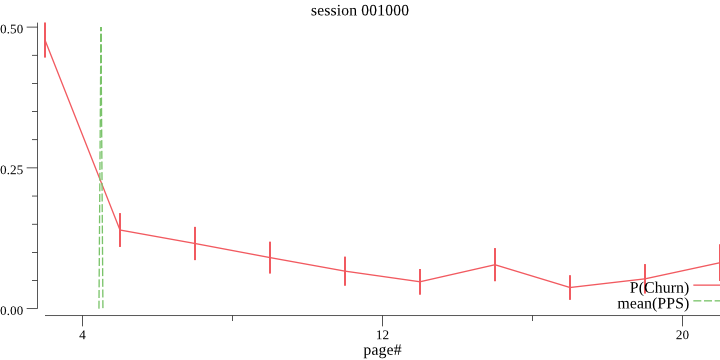

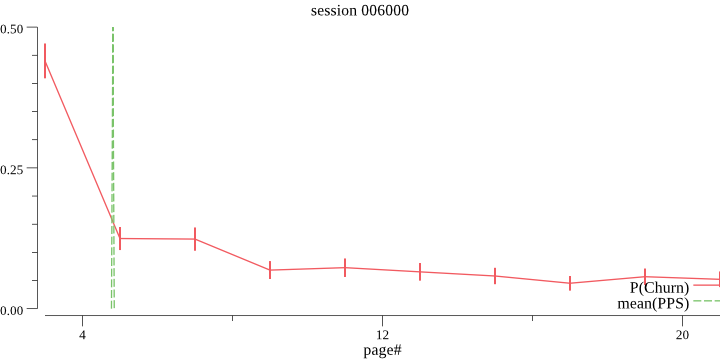

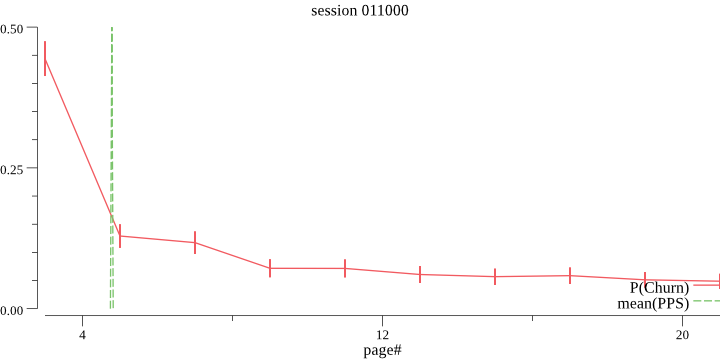

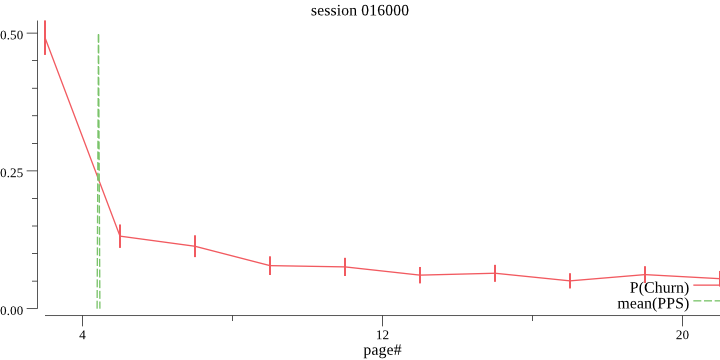

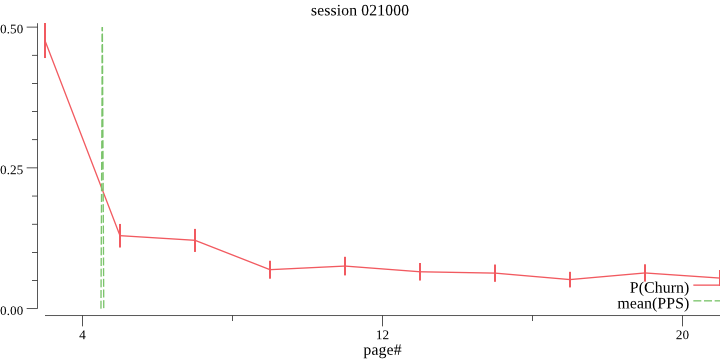

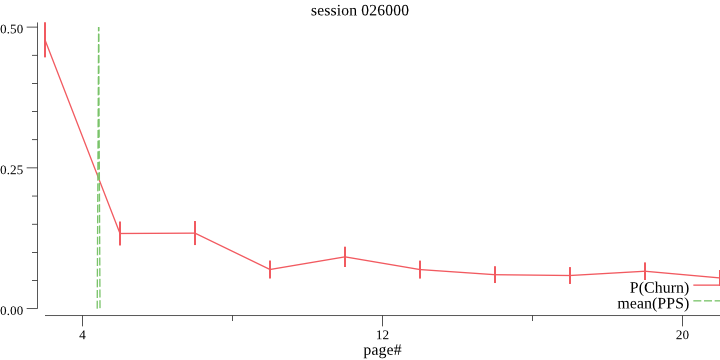

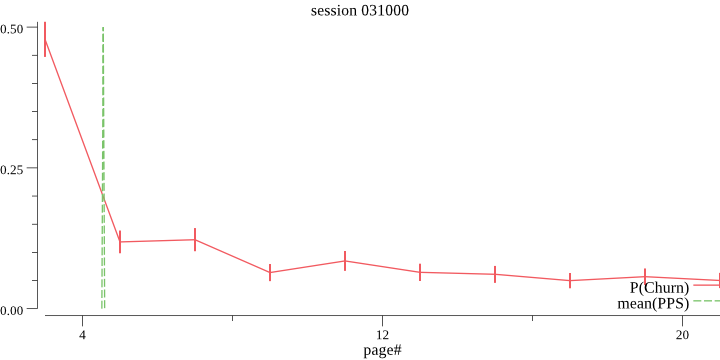

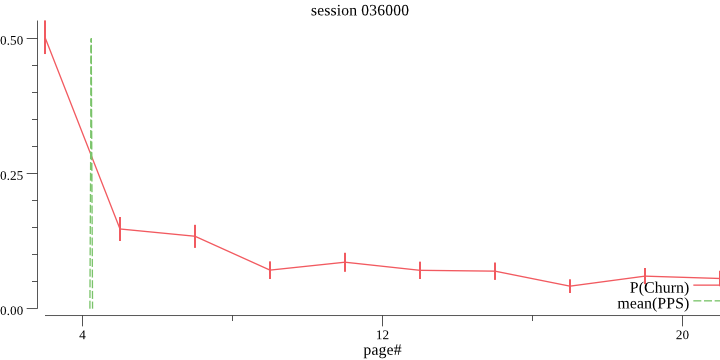

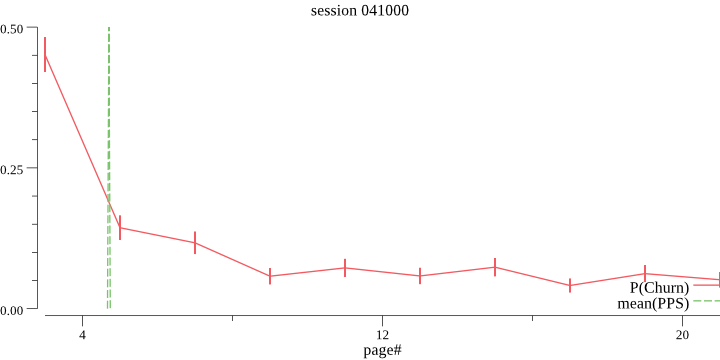

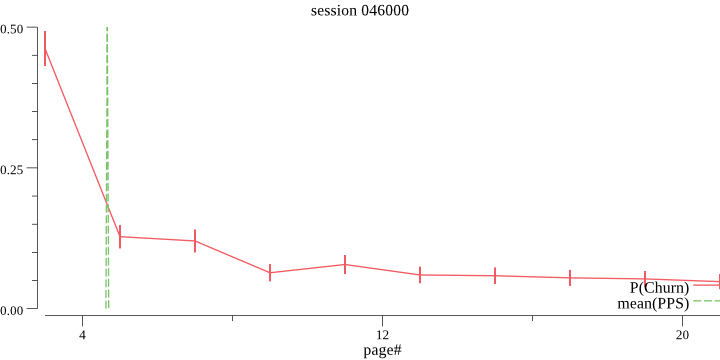

In [9]:
const STEP = 5

for i, record := range plotdata[1:] {
    p, err := plot.New()

    if i % STEP != 0 {
        continue
    }
    
    p.Title.Text = fmt.Sprintf("session %v", record[0])
    p.X.Label.Text = "page#"
    
    mean, std, pts := points(record)
    plotutil.AddLines(p, 
                      "P(Churn)", pts, 
                      "mean(PPS)", plotter.XYs{{mean - Z*std, 0}, 
                                               {mean, 0.5}, 
                                               {mean + Z*std, 0.}})
    
    
    const dpi = 120

    img := (image.NewRGBA(image.Rect(0, 0, 6*dpi, 3*dpi)))
    c := vgimg.NewWith(vgimg.UseImage(img))
    p.Draw(draw.New(c))
    Display(display.Image(img))
}